<a href="https://colab.research.google.com/github/sijiao-liu/deep_learning/blob/lab/01_materials/labs/lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommender Systems

In this lab, we'll be using Keras to build a recommender system. We'll be using the MovieLens dataset, a common benchmark dataset for recommender systems.

MovieLens is a web-based recommender system and virtual community that recommends movies for its users to watch, based on their film preferences using collaborative filtering of members' movie ratings and movie reviews. You can check out the website here: https://movielens.org/

We will download a subset of the dataset containing 100k ratings. There are tens of millions of ratings in the full dataset, spanning hundreds of thousands of users and movies. The subset we'll be using is a good example to demonstrate the concepts in this lab.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile
from urllib.request import urlretrieve
from pathlib import Path

ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = Path("ml-100k.zip")
ML_100K_FOLDER = Path("ml-100k")

if not ML_100K_FOLDER.exists():
    if not ML_100K_FILENAME.exists():
        urlretrieve(ML_100K_URL, ML_100K_FILENAME.name)
    with ZipFile(ML_100K_FILENAME.name) as zip:
        zip.extractall()

The goal of MovieLens is to enable models to predict the rating a user would give to a movie they have not yet watched. This is a classic example of a recommendation system. The dataset is huge, and contains many parts giving information about the movies, the users, and the ratings. To begin with, we will look at the ratings file. Each line in the ratings file (u.data) is formatted as:

`user_id, item_id, rating, timestamp`

Which tells us a single user's rating of a single movie.

We will start by loading the ratings data into a pandas dataframe and then take a look at the first few rows. If you haven't used Pandas before, it's an extremely powerful library for dealing with tabular data. You can think of it as a Python version of Excel.

In [2]:
import pandas as pd

raw_ratings = pd.read_csv(ML_100K_FOLDER / "u.data", sep='\t',
                          names=["user_id", "item_id", "rating", "timestamp"])
raw_ratings

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [3]:
raw_ratings.describe()

,user_id,item_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [4]:
raw_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


The second file we'll look at is the movie metadata. This file (u.item) contains information about each movie, including the title and release date. Each line in the file is formatted as:

`movie_id | movie_title | release_date | video_release_date | IMDb_URL | unknown | Action | Adventure | Animation | Children's | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western`

As you can see, the genres are binary variables. As with one-hot encoding, a 1 indicates that the movie is of that genre, and a 0 indicates that it is not. We aren't going to work with the genre data in this lab, but it's easy to imagine that it could be useful in a real-world recommendation system.

In [5]:
columns_to_keep = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(ML_100K_FOLDER / "u.item", sep='|', names=columns_to_keep,
                    encoding='latin-1', usecols=range(5))
items

,item_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)
...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998)
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...


By default, the `release_date` column is a string. We can convert it to a `datetime` object using the `pd.to_datetime` function. This will make it easier to work with in the future (if we want to do things like check which date came first, for example).

We can also extract the year from the date and store it in a separate column. This will make it easier to do things like plot the number of movies released each year.

In [6]:
items['release_date'] = pd.to_datetime(items['release_date']) # Pandas makes this easy!
items['release_year'] = items['release_date'].dt.year # For later use

For our purposes, it will be easier to work with the data if we merge our two dataframes into a single dataframe. We can do this using the `merge` method. We'll merge the `items` dataframe into the `raw_ratings` dataframe, using the `item_id` column as the key. This will add the movie title and release year to each rating.

In [7]:
all_ratings = pd.merge(items, raw_ratings)

In [8]:
all_ratings.head()

,item_id,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,308,4,887736532
1,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,287,5,875334088
2,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,148,4,877019411
3,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,280,4,891700426
4,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,66,3,883601324


### Data preprocessing

It's always important to understand the data you've collected. Thankfully, Pandas continues to make this easy for us. Using the `describe` method, we can get a quick statistical summary of the data.

In [9]:
all_ratings.describe()

,item_id,release_date,video_release_date,release_year,user_id,rating,timestamp
count,100000.000000,99991,0.0,99991.000000,100000.00000,100000.000000,1.000000e+05
mean,425.530130,1988-02-09 00:43:11.369223296,NaN,1987.956216,462.48475,3.529860,8.835289e+08
min,1.000000,1922-01-01 00:00:00,NaN,1922.000000,1.00000,1.000000,8.747247e+08
25%,175.000000,1986-01-01 00:00:00,NaN,1986.000000,254.00000,3.000000,8.794487e+08
50%,322.000000,1994-01-01 00:00:00,NaN,1994.000000,447.00000,4.000000,8.828269e+08
75%,631.000000,1996-09-28 00:00:00,NaN,1996.000000,682.00000,4.000000,8.882600e+08
max,1682.000000,1998-10-23 00:00:00,NaN,1998.000000,943.00000,5.000000,8.932866e+08
std,330.798356,NaN,NaN,14.155523,266.61442,1.125674,5.343856e+06


Let's do a bit more pandas magic to compute the popularity of each movie (number of ratings). We will use the `groupby` method to group the dataframe by the `item_id` column and then use the `size` method to compute the number of ratings for each movie. We will use the `reset_index` method to convert the resulting Series into a dataframe with an `item_id` column.

In [10]:
popularity = all_ratings.groupby('item_id').size().reset_index(name='popularity')
items = pd.merge(popularity, items)

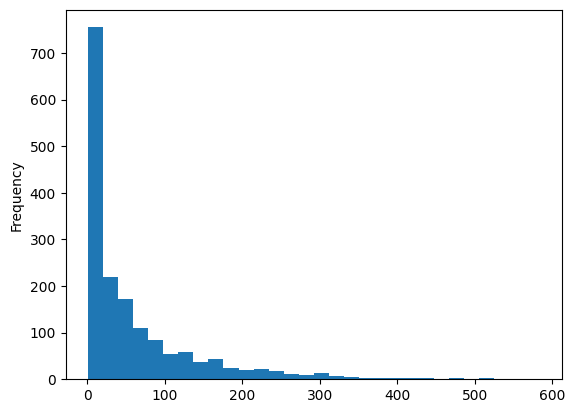

In [11]:
items['popularity'].plot.hist(bins=30);

In [12]:
(items['popularity'] == 1).sum() # Number of movies with only one rating

141

In [13]:
items.nlargest(10, 'popularity')['title'] # Get the 10 most popular movies

,title
49,Star Wars (1977)
257,Contact (1997)
99,Fargo (1996)
180,Return of the Jedi (1983)
293,Liar Liar (1997)
285,"English Patient, The (1996)"
287,Scream (1996)
0,Toy Story (1995)
299,Air Force One (1997)
120,Independence Day (ID4) (1996)


In [14]:
all_ratings = pd.merge(popularity, all_ratings)
all_ratings.describe()

,item_id,popularity,release_date,video_release_date,release_year,user_id,rating,timestamp
count,100000.000000,100000.000000,99991,0.0,99991.000000,100000.00000,100000.000000,1.000000e+05
mean,425.530130,168.071900,1988-02-09 00:43:11.369223296,NaN,1987.956216,462.48475,3.529860,8.835289e+08
min,1.000000,1.000000,1922-01-01 00:00:00,NaN,1922.000000,1.00000,1.000000,8.747247e+08
25%,175.000000,71.000000,1986-01-01 00:00:00,NaN,1986.000000,254.00000,3.000000,8.794487e+08
50%,322.000000,145.000000,1994-01-01 00:00:00,NaN,1994.000000,447.00000,4.000000,8.828269e+08
75%,631.000000,239.000000,1996-09-28 00:00:00,NaN,1996.000000,682.00000,4.000000,8.882600e+08
max,1682.000000,583.000000,1998-10-23 00:00:00,NaN,1998.000000,943.00000,5.000000,8.932866e+08
std,330.798356,121.784558,NaN,NaN,14.155523,266.61442,1.125674,5.343856e+06


In [15]:
indexed_items = items.set_index('item_id')

In [16]:
all_ratings.head()

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,308,4,887736532
1,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,287,5,875334088
2,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,148,4,877019411
3,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,280,4,891700426
4,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,66,3,883601324


**Quick Exercise**:

As we have seen, the `groupby` method is a powerful tool to quickly compute statistics on the data. Use it to compute the average rating for each movie.

**Hint**: you can use the `mean` method after the `groupby` method.

In [17]:
all_ratings.groupby('title')['rating'].mean()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390
...,...
Young Guns II (1990),2.772727
"Young Poisoner's Handbook, The (1995)",3.341463
Zeus and Roxanne (1997),2.166667


Let's split the enriched data in a train / test split to make it possible to do predictive modeling:

In [18]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

user_id_train = np.array(ratings_train['user_id'])
item_id_train = np.array(ratings_train['item_id'])
rating_train = np.array(ratings_train['rating'])

user_id_test = np.array(ratings_test['user_id'])
item_id_test = np.array(ratings_test['item_id'])
rating_test = np.array(ratings_test['rating'])

# Explicit feedback: supervised ratings prediction

Now let's begin to do some recommendation! We will build a model that takes a user and a movie as input and outputs a predicted rating. We will be taking advantage of embeddings to represent users and movies. That means that each movie and user will have an abstract representation in a continuous vector space. The model will learn these representations based on the ratings.

## Predictive ratings  as a regression problem

The following code implements the following architecture:

<img src="https://raw.githubusercontent.com/UofT-DSI/deep_learning/main/notebooks/images/rec_archi_1.svg" style="width: 600px;" />

In [19]:
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.layers import Dot
from tensorflow.keras.models import Model

In [20]:
# For each sample we input the integer identifiers
# of a single user and a single item
class RegressionModel(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding')

        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.dot = Dot(axes=1)

    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.flatten(self.user_embedding(user_inputs))
        item_vecs = self.flatten(self.item_embedding(item_inputs))

        y = self.dot([user_vecs, item_vecs])
        return y


model = RegressionModel(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max())
model.compile(optimizer="adam", loss='mae')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Monitoring runs

When training a model with Keras, we get a `history` object back that contains lots of information about the training run. We can use this to plot the training and validation loss to see how the model has improved during training.

In [21]:
%%time

# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.2957 - val_loss: 1.0368
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8968 - val_loss: 0.7948
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7547 - val_loss: 0.7665
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.7273 - val_loss: 0.7580
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7054 - val_loss: 0.7496
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6822 - val_loss: 0.7470
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6633 - val_loss: 0.7400
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6353 - val_loss: 0.7366
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6134 - val_loss: 0.7393
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5940 - val_loss: 0.7392
CPU times: user 35.7 s, sys: 2.85 s, total: 38.5 s
Wall time: 40.1 s


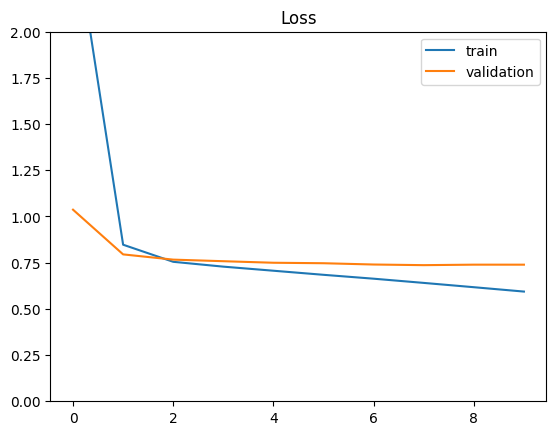

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

**Questions**:

- Does it look like our model has overfit? Why or why not?
- Suggest something we could do to prevent overfitting.


Now that the model is trained, let's check out the quality of predictions:

In [23]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(4, 4))
    plt.xlim(-1, 6)
    plt.xlabel("True rating")
    plt.ylim(-1, 6)
    plt.ylabel("Predicted rating")
    plt.scatter(y_true, y_pred, s=60, alpha=0.01)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final test MSE: 0.899
Final test MAE: 0.732


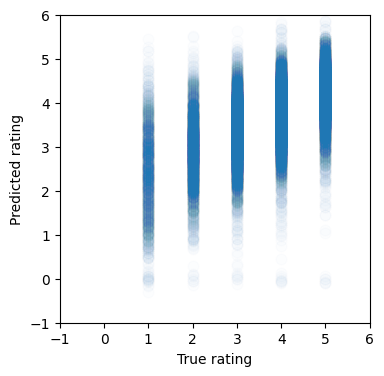

In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))
plot_predictions(rating_test, test_preds)

This graph shows us the range of predicted ratings our model gives, organized by the true rating. We can see that generally, the higher the true rating the higher the predicted rating, although there is quite a range of predictions for each instance. That's okay - our model is very simple, and human preferences are very complex!

Taking a look at the Mean Absolute Error, hopefully you got something around 0.75. This means that, on average, our predicted ratings are about 0.75 stars off from the true ratings. This is a pretty good result for a first attempt. We could probably do better with a more complex model, but we'll leave that for another time.

### Model Embeddings

Our model was built with two embedding layers. These layers have learned a representation of both the users and the movies in our dataset. We can extract these representations and use them to find similar movies or users. We can also do interesting exploratory analysis, like finding the most popular movies among our users, or finding the users that are most interested in a given movie.

In [25]:
# weights and shape
weights = model.get_weights()
[w.shape for w in weights]

[(944, 64), (1683, 64)]

In [26]:
user_embeddings = weights[0]
item_embeddings = weights[1]

In [27]:
item_id = 181
print(f"Title for item_id={item_id}: {indexed_items['title'][item_id]}")

Title for item_id=181: Return of the Jedi (1983)


In [28]:
print(f"Embedding vector for item_id={item_id}")
print(item_embeddings[item_id])
print("shape:", item_embeddings[item_id].shape)

Embedding vector for item_id=181
[ 0.2484225  -0.27134493  0.23555379  0.23137134  0.41104302 -0.19763105
 -0.44855982 -0.1013943  -0.31204855 -0.22297554 -0.24314    -0.16558695
 -0.09787264  0.15659623  0.38615385 -0.29816043  0.3267303   0.12675406
  0.46747506 -0.07778513  0.20208584 -0.29357427 -0.54535717 -0.35215652
 -0.1808653  -0.01369147 -0.18177088  0.27522704  0.17678109 -0.00670197
 -0.36903474  0.357879   -0.3716127  -0.4655962   0.47712743 -0.32701036
  0.37877154 -0.07235672  0.07863365  0.40078536 -0.20356986  0.20618622
  0.2171014   0.38299984 -0.4990574   0.45194995 -0.49338976 -0.20182316
  0.34010124  0.24526402 -0.5271881   0.33444792  0.44088405  0.2596537
  0.38389045 -0.21043646  0.5179928   0.36260167  0.2382492  -0.36752704
 -0.19881481  0.40978712  0.25861898  0.06834878]
shape: (64,)


As we discussed in lecture, our embeddings are not directly interpretable - we can't look at, say, a value of 0.297 in the embedding vector and say "this means that the movie is a drama". As an aside, there is a field of research dedicated to making _interpretable_ embeddings, but it's not something we'll cover in this course.

### Finding our most similar items

Now we can have some fun, investigating the embeddings we've learned. We can start by finding the most similar items to a given item. We can do this by computing the cosine similarity between the item's embedding and the embedding of every other item. We can use the `cosine_similarity` function from `sklearn` to do this.

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine(a, b):
    # Reshape to the shape our function expects
    a = a.reshape(1, -1)
    b = b.reshape(1, -1)
    return cosine_similarity(a, b)[0, 0]

In [30]:
def print_similarity(item_a, item_b, item_embeddings, titles):
    print(titles[item_a])
    print(titles[item_b])
    similarity = cosine(item_embeddings[item_a],
                        item_embeddings[item_b])
    print(f"Cosine similarity: {similarity:.3}")

print_similarity(50, 181, item_embeddings, indexed_items["title"])

Star Wars (1977)
Return of the Jedi (1983)
Cosine similarity: 0.899


It makes sense that the original Star Wars, and its later sequel Return of the Jedi have a high similarity. Let's try some other examples:

In [31]:
print_similarity(181, 288, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Scream (1996)
Cosine similarity: 0.755


In [32]:
print_similarity(181, 1, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Toy Story (1995)
Cosine similarity: 0.846


In [33]:
print_similarity(181, 181, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Return of the Jedi (1983)
Cosine similarity: 1.0


*Quick Exercise*:

- Find some other films and compare their similarity. Do the results make sense to you? Can you find a pair of films that are very _dissimilar_?

In [34]:
# Code to help you search for a movie title
partial_title = "Jedi"
indexed_items[indexed_items['title'].str.contains(partial_title)]

,popularity,title,release_date,video_release_date,imdb_url,release_year
item_id,,,,,,
181,507,Return of the Jedi (1983),1997-03-14,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,1997.0


In [35]:
# Code to help you search for a movie title
partial_title = "Toy"
indexed_items[indexed_items['title'].str.contains(partial_title)]

,popularity,title,release_date,video_release_date,imdb_url,release_year
item_id,,,,,,
1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0


Sometimes, even without knowing anything about a user, we can recommend films by asking them about a film that they do like. The code below compares the similarity of a given film to all others, and returns the most similar films.

In [36]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def most_similar(item_id, item_embeddings, titles,
                 top_n=30):

    """
    Finds the most similar items to a given item.

    Args:
        item_id: The ID of the item to find similar items for.
        item_embeddings: A matrix of item embeddings.
        titles: A list of item titles.
        top_n: The number of most similar items to return.

    Returns:
        A list of tuples, where each tuple contains the ID, title, and similarity
        score of a similar item.
    """

    # Compute the cosine similarity between the item and all other items
    sims = cosine_similarity(item_embeddings[item_id].reshape(1, -1),
                             item_embeddings).ravel()

    # [::-1] makes it possible to reverse the order of a numpy
    # array, this is required because most similar items have
    # a larger cosine similarity value
    sorted_indexes = np.argsort(sims)[::-1]
    idxs = sorted_indexes[0:top_n]
    return list(builtins.zip(idxs, titles[idxs], sims[idxs]))

# Import the builtins module to access the original zip function
import builtins

# Find the most similar films to "Star Wars"
most_similar(50, item_embeddings, indexed_items["title"], top_n=10)

[(50, 'Star Wars (1977)', 1.0),
 (172, 'Empire Strikes Back, The (1980)', 0.90135807),
 (181, 'Return of the Jedi (1983)', 0.8988605),
 (12, 'Usual Suspects, The (1995)', 0.8885641),
 (174, 'Raiders of the Lost Ark (1981)', 0.87876856),
 (96, 'Terminator 2: Judgment Day (1991)', 0.85403013),
 (293, 'Donnie Brasco (1997)', 0.85382974),
 (1550, 'Destiny Turns on the Radio (1995)', 0.8494264),
 (313, 'Titanic (1997)', 0.84774494),
 (169, 'Wrong Trousers, The (1993)', 0.8473503)]

In [37]:
# Find the most similar films to "Star Trek VI: The Undiscovered Country"
most_similar(227, item_embeddings, indexed_items["title"], top_n=10)

[(227, 'Star Trek VI: The Undiscovered Country (1991)', 0.9999999),
 (230, 'Star Trek IV: The Voyage Home (1986)', 0.8973218),
 (228, 'Star Trek: The Wrath of Khan (1982)', 0.8917751),
 (662, 'Somewhere in Time (1980)', 0.8772391),
 (674, 'Cat People (1982)', 0.87487304),
 (1314, 'Surviving the Game (1994)', 0.87144554),
 (1469, 'Tom and Huck (1995)', 0.86855376),
 (290, 'Fierce Creatures (1997)', 0.8627968),
 (91, 'Nightmare Before Christmas, The (1993)', 0.8595878),
 (466, 'Red Rock West (1992)', 0.85134083)]

The similarities do not always make sense: the number of ratings is low and the embedding  does not automatically capture semantic relationships in that context. Better representations arise with higher number of ratings, and less overfitting  in models or maybe better loss function, such as those based on implicit feedback.

### Visualizing embeddings using TSNE

The [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) algorithm enables us to visualize high dimensional vectors in a 2D space by preserving local neighborhoods. We can use it to get a 2D visualization of the item embeddings and see if similar items are close in the embedding space.

In [38]:
from sklearn.manifold import TSNE

item_tsne = TSNE(learning_rate="auto", init="pca", perplexity=30).fit_transform(item_embeddings)

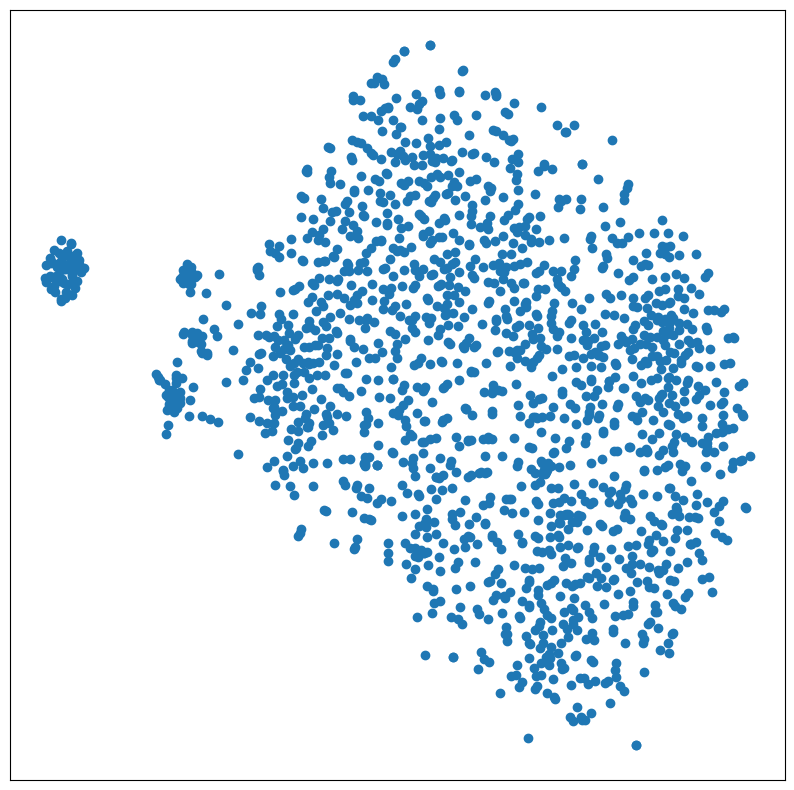

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

In [40]:
import plotly.express as px

tsne_df = pd.DataFrame(item_tsne, columns=["tsne_1", "tsne_2"])
tsne_df["item_id"] = np.arange(item_tsne.shape[0])
tsne_df = tsne_df.merge(items.reset_index())

px.scatter(tsne_df, x="tsne_1", y="tsne_2",
           color="popularity",
           hover_data=["item_id", "title", "popularity"])

### Exercises

 - Add another layer to the neural network and retrain, compare train/test error.
 - Try adding more dropout and change layer sizes.


### A recommendation function for a given user

Once the model is trained, the system can be used to recommend a few items for a user that they haven't seen before. The following code does that.

- we use the `model.predict` to compute the ratings a user would have given to all items
- we build a function that sorts these items and excludes those the user has already seen.

In [41]:
def recommend(user_id, top_n=10):
    item_ids = range(1, items['item_id'].max())
    seen_mask = all_ratings["user_id"] == user_id
    seen_movies = set(all_ratings[seen_mask]["item_id"])
    item_ids = list(filter(lambda x: x not in seen_movies, item_ids))

    user = np.zeros_like(item_ids)
    user[:len(item_ids)] = user_id
    items_ = np.array(item_ids)
    ratings = model.predict([user, items_]).flatten()
    top_items = ratings.argsort()[-top_n:][::-1]
    return [(indexed_items.loc[item_id]["title"], ratings[item_id]) for item_id in top_items]

In [42]:
for title, pred_rating in recommend(5):
    print("    %0.1f: %s" % (pred_rating, title))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
    4.6: 20,000 Leagues Under the Sea (1954)
    4.4: Rock, The (1996)
    4.4: Loaded (1994)
    4.3: Babe (1995)
    4.3: Get Shorty (1995)
    4.3: Dead Man Walking (1995)
    4.2: Mr. Smith Goes to Washington (1939)
    4.2: Eat Drink Man Woman (1994)
    4.2: Gone with the Wind (1939)
    4.2: Bound (1996)


from tensorflow.keras.optimizers import Adam # import the Adam optimizer### Exercises

- Try modifying our neural network to improve recommendation. You could try adding more layers, or using a different loss function.
- Your goal is to improve the Mean Absolute Error on the test set. Show the results of your best model.

In [43]:
from tensorflow.keras.optimizers import Adam # import the Adam optimizer

# Extend and improve the model below
class RegressionModel(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding')

        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.dot = Dot(axes=1)

    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.flatten(self.user_embedding(user_inputs))
        item_vecs = self.flatten(self.item_embedding(item_inputs))

        y = self.dot([user_vecs, item_vecs])
        return y


model = RegressionModel(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max())

# Adding a custom learning rate to the Adam optimizer
optimizer = Adam(learning_rate = 0.001) # Now Adam is defined

model.compile(optimizer="adam", loss='mae')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



In [44]:
# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3.3163 - val_loss: 1.0511
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9073 - val_loss: 0.7979
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7555 - val_loss: 0.7668
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7242 - val_loss: 0.7608
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7035 - val_loss: 0.7476
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6855 - val_loss: 0.7415
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6595 - val_loss: 0.7371
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6432 - val_loss: 0.7371
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6184 - val_loss: 0.7360
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5905 - val_loss: 0.7341


In [45]:
# Extend and improve the model below
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Flatten, Dot, Dense
from tensorflow.keras.models import Model


class RegressionModelV2(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding')

        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.dot = Dot(axes=1)

        # Additional layers
        self.user_transform_layer = Dense(64, activation = 'relu')
        self.item_transform_layer = Dense(64, activation = 'relu')


    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.flatten(self.user_transform_layer(self.user_embedding(user_inputs)))
        item_vecs = self.flatten(self.item_transform_layer(self.item_embedding(item_inputs)))


        y = self.dot([user_vecs, item_vecs])
        return y


model_V2 = RegressionModelV2(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max())

# Adding a custom learning rate to the Adam optimizer
optimizer = Adam(learning_rate = 3e-4)

# Call compile on model_V2 instead of model
model_V2.compile(optimizer=optimizer, loss='mae') # Changed from model to model_V2

In [46]:
# Training the model
history = history_v2 = model_V2.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2.0326 - val_loss: 0.7725
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.7508 - val_loss: 0.7587
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7370 - val_loss: 0.7547
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7352 - val_loss: 0.7511
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7309 - val_loss: 0.7471
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.7195 - val_loss: 0.7439
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.7141 - val_loss: 0.7444
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7069 - val_loss: 0.7369
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6954 - val_loss: 0.7335
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6832 - val_loss: 0.7314


In [47]:
# Simplified and improved version of the model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Simplified and improved model version
class RegressionModelV3(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        # Simplify the embedding with a smaller size and reduced regularization
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding',
                                        embeddings_regularizer=l2(0.005))
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding',
                                        embeddings_regularizer=l2(0.005))

        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.dot = Dot(axes=1)

        # Single transform layers with reduced complexity
        self.user_transform_layer = Dense(32, activation='relu', kernel_regularizer=l2(0.005))
        self.item_transform_layer = Dense(32, activation='relu', kernel_regularizer=l2(0.005))

        # Dropout layer with reduced rate
        self.dropout = Dropout(0.1)

    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.flatten(self.user_transform_layer(self.user_embedding(user_inputs)))
        user_vecs = self.dropout(user_vecs)

        item_vecs = self.flatten(self.item_transform_layer(self.item_embedding(item_inputs)))
        item_vecs = self.dropout(item_vecs)

        y = self.dot([user_vecs, item_vecs])
        return y

# Instantiate the updated model
model_v3 = RegressionModelV3(embedding_size=16,
                             max_user_id=all_ratings['user_id'].max(),
                             max_item_id=all_ratings['item_id'].max())

# Use Adam optimizer with a reduced learning rate
optimizer_v3 = Adam(learning_rate=3e-4)

# Compile the updated model with MAE loss function
model_v3.compile(optimizer=optimizer_v3, loss='mae')

# Adding EarlyStopping to avoid overfitting
early_stopping_v3 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [48]:
# Training the updated model
history_v3 = model_v3.fit([user_id_train, item_id_train], rating_train,
                          batch_size=64, epochs=20, validation_split=0.1,
                          shuffle=True, callbacks=[early_stopping_v3])

Epoch 1/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.8322 - val_loss: 0.9873
Epoch 2/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9422 - val_loss: 0.8829
Epoch 3/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8677 - val_loss: 0.8621
Epoch 4/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8494 - val_loss: 0.8578
Epoch 5/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8463 - val_loss: 0.8549
Epoch 6/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8412 - val_loss: 0.8554
Epoch 7/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8440 - val_loss: 0.8553
Epoch 8/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8461 - val_loss: 0.8548
Epoch 9/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8404 - val_loss: 0.8543
Epoch 10/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8473 - val_loss: 0.8544
Epoch 11/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8427 - val_loss: 0.8546
Epoch 12/20
1125/1125 ━━━━━━━━